In [25]:
#Load and Check Data
import numpy as np
import pandas as pd
import datetime as dt
from prophet import Prophet

data = pd.read_csv("../raw_data/TSLA.csv",parse_dates = True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-10,45.478001,45.594002,43.683998,43.757999,43.757999,30133000
1,2016-06-13,43.900002,45.153999,43.532001,43.574001,43.574001,20965000
2,2016-06-14,43.776001,44.439999,42.506001,42.992001,42.992001,17901000
3,2016-06-15,43.389999,44.380001,43.026001,43.540001,43.540001,14542500
4,2016-06-16,43.484001,43.608002,42.700001,43.585999,43.585999,12201500


In [27]:
data['Date'] = pd.to_datetime(data['Date'])

In [28]:
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [29]:
data.shape

(1258, 7)

In [30]:
#Split the data as train and test

training_size = int(len(data)*0.80)
data_len = len(data)

train, test = data[0:training_size],data[training_size:data_len]

In [31]:
print("Training Size --> ", training_size)
print("total length of data --> ", data_len)
print("Train length --> ", len(train))
print("Test length --> ", len(test))

Training Size -->  1006
total length of data -->  1258
Train length -->  1006
Test length -->  252


In [32]:
# Normalize data 
# the part of data that we will use as training.
train = train.loc[:, ["Adj Close"]].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
train_scaled 

array([[0.05165056],
       [0.05045724],
       [0.04668268],
       ...,
       [0.91664835],
       [1.        ],
       [0.98800187]])

In [33]:
import numpy as np

#We will separate the normalized data into x_train and y_train.
#We will make this distinction 40 steps 40 steps. So we will train in 40 steps


end_len = len(train_scaled)
X_train = []
y_train = []
timesteps = 40

for i in range(timesteps, end_len):
    X_train.append(train_scaled[i - timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [34]:
# Reshape

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print("X_train --> ", X_train.shape)
print("y_train shape --> ", y_train.shape)

X_train -->  (966, 40, 1)
y_train shape -->  (966,)


In [35]:
# LSTM model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [36]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

In [37]:
# Compile Model
regressor.compile(optimizer= "adam", loss = "mean_squared_error")

In [38]:
epochs = 50 
batch_size = 32

In [39]:
# Fit the model 

regressor.fit(X_train, y_train, epochs = epochs, batch_size = batch_size)

Epoch 1/50
31/31 [==============================] - 9s 79ms/step - loss: 0.0290
Epoch 2/50
31/31 [==============================] - 2s 79ms/step - loss: 0.0078
Epoch 3/50
31/31 [==============================] - 3s 83ms/step - loss: 0.0065
Epoch 4/50
31/31 [==============================] - 2s 75ms/step - loss: 0.0052
Epoch 5/50
31/31 [==============================] - 2s 76ms/step - loss: 0.0057
Epoch 6/50
31/31 [==============================] - 2s 78ms/step - loss: 0.0034
Epoch 7/50
31/31 [==============================] - 2s 73ms/step - loss: 0.0033
Epoch 8/50
31/31 [==============================] - 2s 72ms/step - loss: 0.0031
Epoch 9/50
31/31 [==============================] - 2s 75ms/step - loss: 0.0026
Epoch 10/50
31/31 [==============================] - 2s 72ms/step - loss: 0.0031
Epoch 11/50
31/31 [==============================] - 2s 74ms/step - loss: 0.0032
Epoch 12/50
31/31 [==============================] - 2s 74ms/step - loss: 0.0029
Epoch 13/50
31/31 [==================

In [40]:
# Predict 

test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1006,2020-06-10,198.376007,205.496002,196.500000,205.009995,205.009995,92817000
1007,2020-06-11,198.039993,203.792007,194.399994,194.567993,194.567993,79582500
1008,2020-06-12,196.000000,197.595993,182.520004,187.056000,187.056000,83817000
1009,2020-06-15,183.557999,199.768005,181.699997,198.179993,198.179993,78486000
1010,2020-06-16,202.369995,202.576004,192.477997,196.425995,196.425995,70255500


In [48]:
# We use the data we separated above as our test data

real_price = test.loc[:, ["Adj Close"]].values
print("Real Price Shape --> ", real_price.shape)

Real Price Shape -->  (252, 1)


In [49]:
dataset_total = pd.concat((data["Adj Close"], test["Adj Close"]), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)

In [55]:
X_test = []

for i in range(timesteps, 500):
    X_test.append(inputs[i-timesteps:i, 0])
    
X_test = np.array(X_test)

print("X_test shape --> ", X_test.shape)

X_test shape -->  (460,)


In [56]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predict = regressor.predict(X_test)
predict = scaler.inverse_transform(predict)

IndexError: tuple index out of range

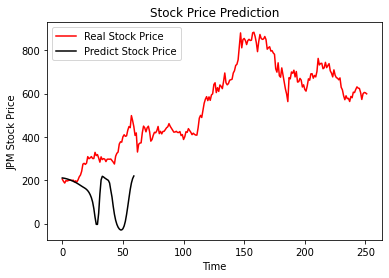

In [57]:
import matplotlib.pyplot as plt

plt.plot(real_price, color = "red", label = "Real Stock Price")
plt.plot(predict, color = "black", label = "Predict Stock Price")
plt.title("Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("JPM Stock Price")
plt.legend()
plt.show()